# RFM: Recency-Frequency-Monetary

Estos son los 3 principales atributos con los que podemos segmentar a nuestros clientes para una mejor publicidad, así como para un mejor servicio al cliente.

    Recency (Recencia): Qué tan recientemente ha realizado el cliente compras. Un cliente más reciente tiene un mejor valor para el negocio y sus comentarios tienen un mayor impacto.

    Frequency (Frecuencia): Qué tan frecuentemente un cliente ha realizado compras. Naturalmente, estos son clientes leales y se les pueden ofrecer nuevos descuentos u ofertas.

    Monetary (Monetario): Cuánto dinero gasta un cliente en sus compras. Cuanto mayor es el gasto, más valioso es el cliente.

Por lo tanto, el negocio debe buscar clientes que tengan una mayor frecuencia y valor monetario y una menor recencia.

Vamos a dividir a los clientes mediante estos atributos:

In [1]:
import pyspark.pandas as ps
from pyspark import SparkContext
from pyspark.sql import SparkSession
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

warnings.filterwarnings('ignore')

spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .config("spark.ui.showConsoleProgress", "false") \
    .config("spark.jars", """
            /usr/local/spark/jars/aws-java-sdk-bundle-1.12.262.jar,
            /usr/local/spark/jars/antlr4-runtime-4.9.3.jar,
            /usr/local/spark/jars/delta-contribs_2.12-3.1.0.jar,
            /usr/local/spark/jars/delta-iceberg_2.12-3.1.0.jar,
            /usr/local/spark/jars/delta-spark_2.12-3.1.0.jar,
            /usr/local/spark/jars/delta-storage-3.1.0.jar,
            /usr/local/spark/jars/hadoop-aws-3.3.4.jar""") \
    .appName("SparkTest") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

%load_ext sparksql_magic
%config SparkSql.limit=20

/opt/conda/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
24/08/16 04:39:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/16 04:39:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Leemos el CSV con pandas.spark para tener pandas funcioanando con Spark
data_dir = 's3a://data/new_retail_data.csv'
df = ps.read_csv(data_dir)

In [3]:
df.head(1)

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,Age,Gender,Income,Customer_Segment,Date,Year,Month,Time,Total_Purchases,Amount,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,21.0,Male,Low,Regular,9/18/2023,2023.0,September,2024-08-16 22:03:55,3.0,108.028757,324.08627,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts


In [4]:
# Agarramos las columnas que precisamos del df
rfm = df[['Customer_ID', 'Total_Amount','Date','Transaction_ID']].to_pandas()
rfm.dtypes
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302010 entries, 0 to 302009
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Customer_ID     301702 non-null  float64
 1   Total_Amount    301660 non-null  float64
 2   Date            301651 non-null  object 
 3   Transaction_ID  301677 non-null  float64
dtypes: float64(3), object(1)
memory usage: 11.5+ MB


In [5]:
# Eliminamos duplicados y nulls
rfm.drop_duplicates(inplace=True)
rfm.dropna(inplace=True)

In [6]:
# Cambiamos los tipos de las columnas
rfm['Date'] = ps.to_datetime(rfm['Date'])
rfm['Transaction_ID'] = rfm['Transaction_ID'].astype(int)
rfm['Customer_ID'] = rfm['Customer_ID'].astype(int)

In [7]:
# Rfm Monetary
rfm_m = rfm.groupby('Customer_ID')['Total_Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['Customer_ID', 'Monetary']
rfm_m.head()

,Customer_ID,Monetary
0,10000,5007.566357
1,10001,8136.462824
2,10002,4104.013951
3,10003,2340.496447
4,10004,2356.516683


In [8]:
# Rfm Frequency
rfm_f = rfm.groupby('Customer_ID')['Transaction_ID'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['Customer_ID', 'Frequency']
rfm_f.head()

,Customer_ID,Frequency
0,10000,4
1,10001,5
2,10002,5
3,10003,2
4,10004,2


In [9]:
# Rfm Recency
max_date = rfm['Date'].max()
rfm['Days_diff'] = (max_date - rfm['Date']).dt.days
rfm_r = rfm.groupby('Customer_ID')['Days_diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r.columns = ['Customer_ID', 'Recency']
rfm_r.head()

,Customer_ID,Recency
0,10000,102
1,10001,104
2,10002,94
3,10003,227
4,10004,30


In [10]:
# Mergeamos los dataframes
rfm_df = rfm[['Customer_ID']]
rfm_df = ps.merge(rfm_df, rfm_r, on='Customer_ID', how='inner')
rfm_df = ps.merge(rfm_df, rfm_f, on='Customer_ID', how='inner')
rfm_df = ps.merge(rfm_df, rfm_m, on='Customer_ID', how='inner')
rfm_df = rfm_df.drop_duplicates()
rfm_df.head()

,Customer_ID,Recency,Frequency,Monetary
0,37249,23,5,6485.389528
1,69749,0,5,4089.881243
2,30192,127,4,7337.481177
3,62101,50,3,7936.809742
4,27901,27,3,1334.931576


In [11]:
# Eliminar Outliers
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicar la función para eliminar outliers en cada columna
rfm_df = remove_outliers_iqr(rfm_df, 'Monetary')
rfm_df = remove_outliers_iqr(rfm_df, 'Recency')
rfm_df = remove_outliers_iqr(rfm_df, 'Frequency')


# Verifica la cantidad de datos filtrados
print(f'Tamaño con Filtros: {rfm_df.shape[0]}')

Tamaño con Filtros: 86720


In [12]:
# Importamos librerias
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Escalamos los datos
features = rfm_df[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

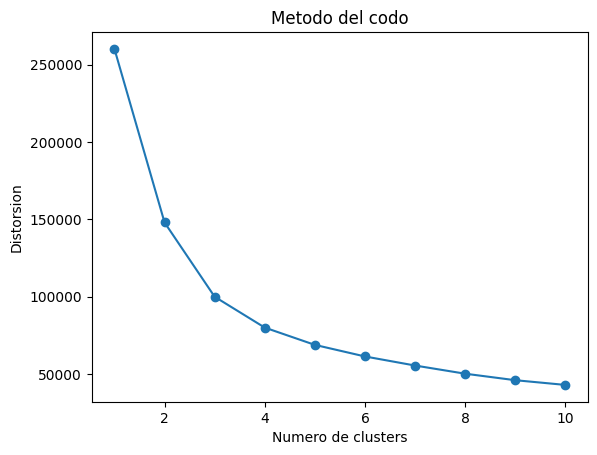

In [13]:
# Usamos el metodo del codo para buscar una cantidad optima de clusters
distortions = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    distortions.append(kmeans.inertia_)
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Numero de clusters')
plt.ylabel('Distorsion')
plt.title('Metodo del codo')
plt.show()

Como el codo entre 2 y 4 no se pronuncia tanto vamos a utilizar 4 clusters, asi podremos segmentar los clientes en 4 partes

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(scaled_features)

In [15]:
# Vemos los  datos para segmentar a los clientes
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean'],
    'Frequency': ['mean'],
    'Monetary': ['mean'],
    'Customer_ID': 'count'
}).reset_index()

# Renombrar columnas para mayor claridad
cluster_summary.columns = ['Cluster_Name', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']
cluster_summary

,Cluster_Name,Avg_Recency,Avg_Frequency,Avg_Monetary,Customer_Count
0,0,64.093699,4.211043,5816.711073,29648
1,1,230.776822,1.926215,2500.594300,17551
2,2,65.649346,2.343060,2534.414514,27520
3,3,48.280310,6.262978,10167.689672,12001


In [16]:
# Segmentamos a los clientes
def cluster_name(cluster_id):
    if cluster_id == 0:
        return "Regular Clients"
    elif cluster_id == 1:
        return "Inactive Clients"
    elif cluster_id == 2:
        return "Occasional Clients"
    elif cluster_id == 3:
        return "Premium Clients"

rfm_df['Cluster_Name'] = rfm_df['Cluster'].apply(cluster_name)

In [18]:
# Resumen estadístico por Cluster
cluster_summary = rfm_df.groupby('Cluster_Name').agg({
    'Recency': ['mean'],
    'Frequency': ['mean'],
    'Monetary': ['mean'],
    'Customer_ID': 'count'
}).reset_index()

# Renombrar columnas para mayor claridad
cluster_summary.columns = ['Cluster_Name', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']

cluster_summary

,Cluster_Name,Avg_Recency,Avg_Frequency,Avg_Monetary,Customer_Count
0,Inactive Clients,230.776822,1.926215,2500.594300,17551
1,Occasional Clients,65.649346,2.343060,2534.414514,27520
2,Premium Clients,48.280310,6.262978,10167.689672,12001
3,Regular Clients,64.093699,4.211043,5816.711073,29648


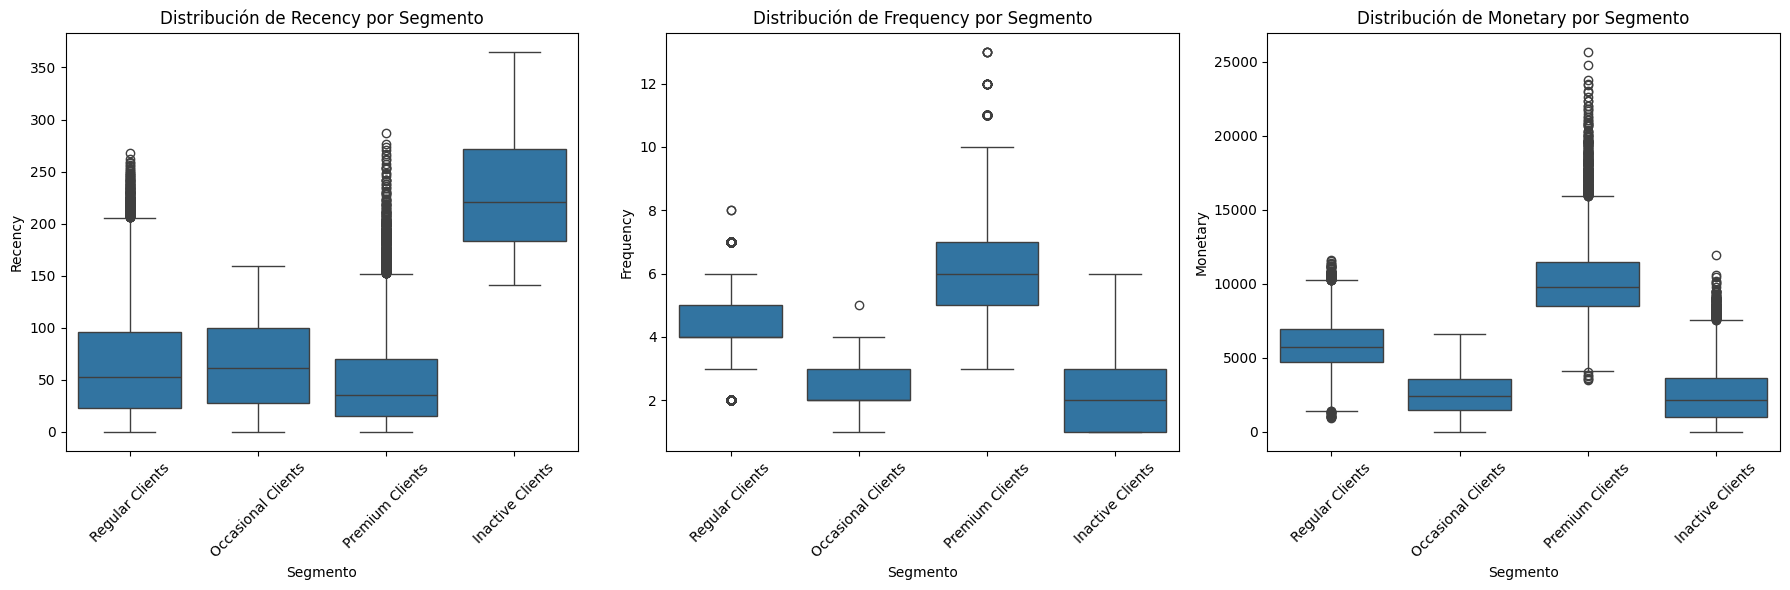

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Visualización de la distribución de Recency por Cluster
sns.boxplot(data=rfm_df, x='Cluster_Name', y='Recency', ax=axes[0])
axes[0].set_title('Distribución de Recency por Segmento')
axes[0].set_xlabel('Segmento')
axes[0].set_ylabel('Recency')
axes[0].tick_params(axis='x', rotation=45)

# Visualización de la distribución de Frequency por Cluster
sns.boxplot(data=rfm_df, x='Cluster_Name', y='Frequency', ax=axes[1])
axes[1].set_title('Distribución de Frequency por Segmento')
axes[1].set_xlabel('Segmento')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

# Visualización de la distribución de Monetary por Cluster
sns.boxplot(data=rfm_df, x='Cluster_Name', y='Monetary', ax=axes[2])
axes[2].set_title('Distribución de Monetary por Segmento')
axes[2].set_xlabel('Segmento')
axes[2].set_ylabel('Monetary')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Análisis de Segmentos (Clusters)

### Clientes Inactivos

    Promedio de Recency: 230.78 días (muy alto, inactivos por mucho tiempo)
    Promedio de Frequency: 1.93 compras (baja frecuencia)
    Promedio de Monetary: 2500.59 (bajo en comparación con otros grupos)
    Conteo de Clientes: 17,551 (grupo moderado en tamaño)

#### Interpretación: Este grupo tiene la Recency más alta, lo que indica que no han interactuado con la empresa recientemente. Su baja frecuencia de compra y bajo gasto promedio sugieren que podrían necesitar estrategias de reactivación. Podría ser beneficioso implementar campañas específicas para volver a captar su interés.

### Clientes Moderados

    Promedio de Recency: 64.09 días (moderado)
    Promedio de Frequency: 4.21 compras (moderada)
    Promedio de Monetary: 5816.71 (moderado)
    Conteo de Clientes: 29,648 (grupo grande)

#### Interpretación: Estos clientes tienen una frecuencia de compra y un gasto moderado, y la Recency indica que están activos pero no son los más frecuentes. Están en un punto intermedio, por lo que estrategias para mejorar su frecuencia de compra o aumentar su gasto podrían ser efectivas.

### Clientes Ocasionales

    Promedio de Recency: 65.65 días (moderado)
    Promedio de Frequency: 2.34 compras (baja frecuencia)
    Promedio de Monetary: 2534.41 (bajo)
    Conteo de Clientes: 27,520 (grupo grande)

#### Interpretación: Este grupo tiene una frecuencia de compra baja y un gasto relativamente bajo. Aunque su Recency es moderada, la baja frecuencia y gasto indican que podrían beneficiarse de estrategias para aumentar la frecuencia de compra o el valor de cada transacción.

### Clientes Premium

    Promedio de Recency: 48.28 días (bajo, muy activos)
    Promedio de Frequency: 6.26 compras (alta frecuencia)
    Promedio de Monetary: 10167.69 (alto)
    Conteo de Clientes: 12,001 (el grupo más pequeño)

#### Interpretación: Este grupo está compuesto por clientes altamente activos con una alta frecuencia de compra y un alto gasto promedio. Aunque el grupo es pequeño, son los clientes más valiosos. Es importante mantener una relación cercana con ellos y ofrecerles beneficios exclusivos para fomentar su lealtad.

## Recomendaciones

#### Para Clientes Inactivos: Considera implementar campañas de reactivación, como ofertas especiales o recordatorios de productos. Investiga las razones detrás de su inactividad para diseñar estrategias más efectivas.

#### Para Clientes Moderados: Trabaja en aumentar su frecuencia de compra y gasto promedio. Puedes ofrecer incentivos o promociones para motivarles a realizar compras más frecuentes o de mayor valor.

#### Para Clientes Ocasionales: Desarrolla estrategias para aumentar la frecuencia de sus compras. Ofrecer promociones o descuentos exclusivos podría animarles a comprar más a menudo.

#### Para Clientes Premium: Mantén un excelente servicio al cliente y considera ofrecer programas de fidelidad o beneficios exclusivos. Asegúrate de que se sientan valorados y apreciados para maximizar su lealtad.

In [20]:
# Volvemos a convertir el dataframe a pyspark.pandas dataframe

rfm_df = ps.from_pandas(rfm_df)
rfm_df.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 86720 entries, 0 to 298292
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Customer_ID   86720 non-null  int64  
 1   Recency       86720 non-null  int64  
 2   Frequency     86720 non-null  int64  
 3   Monetary      86720 non-null  float64
 4   Cluster       86720 non-null  int32  
 5   Cluster_Name  86720 non-null  object 
dtypes: float64(1), int32(1), int64(3), object(1)

In [21]:
# Mergeamos la columna de Clusters a el df principal
df1 = df
df2 = rfm_df

print(df1.shape)
print(df2.shape)

# Eliminar duplicados y valores nulos
df1 = df1.drop_duplicates()
df1 = df1.dropna()

# Convertir los tipos de datos
df1['Age'] = df1['Age'].astype(int)
df1['Phone'] = df1['Phone'].astype(int)
df1['Ratings'] = df1['Ratings'].astype(int)
df1['Transaction_ID'] = df1['Transaction_ID'].astype(int)
df1['Customer_ID'] = df1['Customer_ID'].astype(int)

df1 = df1.merge(df2[['Customer_ID', 'Cluster_Name']], on='Customer_ID', how='left')

print(df1.shape)

(302010, 30)
(86720, 6)
(293908, 31)


In [22]:
columns = ['Customer_ID', 'Country', 'Age', 'Gender', 'Income', 'Customer_Segment', 
           'Product_Category', 'Product_Brand', 'Product_Type', 
           'Feedback', 'Shipping_Method', 'Payment_Method', 
           'Order_Status', 'Ratings', 'products', 'Cluster_Name']

dfm = df1[columns]

In [23]:
dfm = dfm.rename(columns={"Cluster_Name": "Client_Type"})
dfm.head()

,Customer_ID,Country,Age,Gender,Income,Customer_Segment,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products,Client_Type
0,91501,Australia,37,Male,Medium,Regular,Home Decor,Bed Bath & Beyond,Bathroom,Bad,Standard,PayPal,Processing,1,Toilet paper holder,Regular Clients
1,42852,UK,69,Male,Medium,Regular,Clothing,Nike,Shoes,Excellent,Express,Credit Card,Delivered,5,Espadrilles,Regular Clients
2,79336,USA,26,Male,High,Regular,Electronics,Samsung,Television,Good,Express,Credit Card,Delivered,4,QLED TV,Occasional Clients
3,13248,USA,26,Male,High,Regular,Grocery,Pepsi,Soft Drink,Excellent,Express,Credit Card,Delivered,5,Grape soda,Regular Clients
4,72935,Germany,31,Female,Medium,Regular,Clothing,Nike,T-shirt,Good,Standard,Credit Card,Shipped,4,Graphic tee,Occasional Clients


In [29]:
dfm = dfm.to_spark()
dfm.write.parquet('s3a://data/df_rfm')

24/08/16 04:43:54 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
24/08/16 04:43:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce

## Busqueda de otros datos:

Ahora que tenemos a los clientes distribuidos y clasificados por su "Valor" nos podemos aprovechar de esto y buscar otros insights que nos permitan conocer a nuestros clientes por su tipo, asi podemos realizar las campañas dependiendo y enfocandonos en el Tipo de Cliente y no en la gran masa.

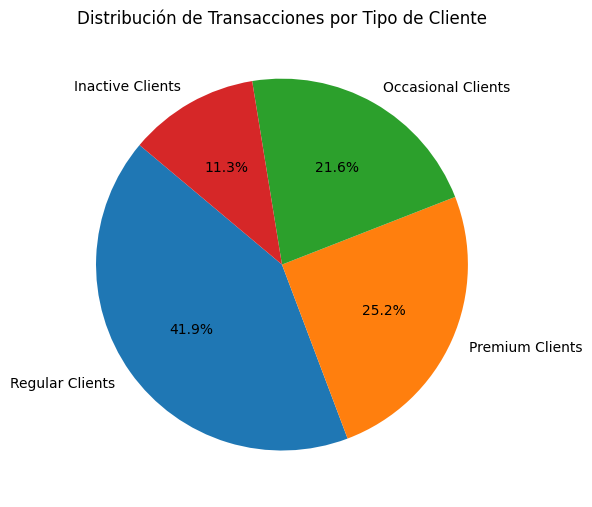

In [24]:
plot0_pandas = dfm['Client_Type'].value_counts().to_pandas()

plt.figure(figsize=(6, 6))

plt.pie(plot0_pandas, labels=plot0_pandas.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Transacciones por Tipo de Cliente')

plt.tight_layout()
plt.show()

#### Interferencia
Como se ve en el grafico los clientes son mayormente Regulares con un 42% y lo siguen los Premium, esto y que la menor cantidad de clientes sea la inactiva habla muy bien del negocio



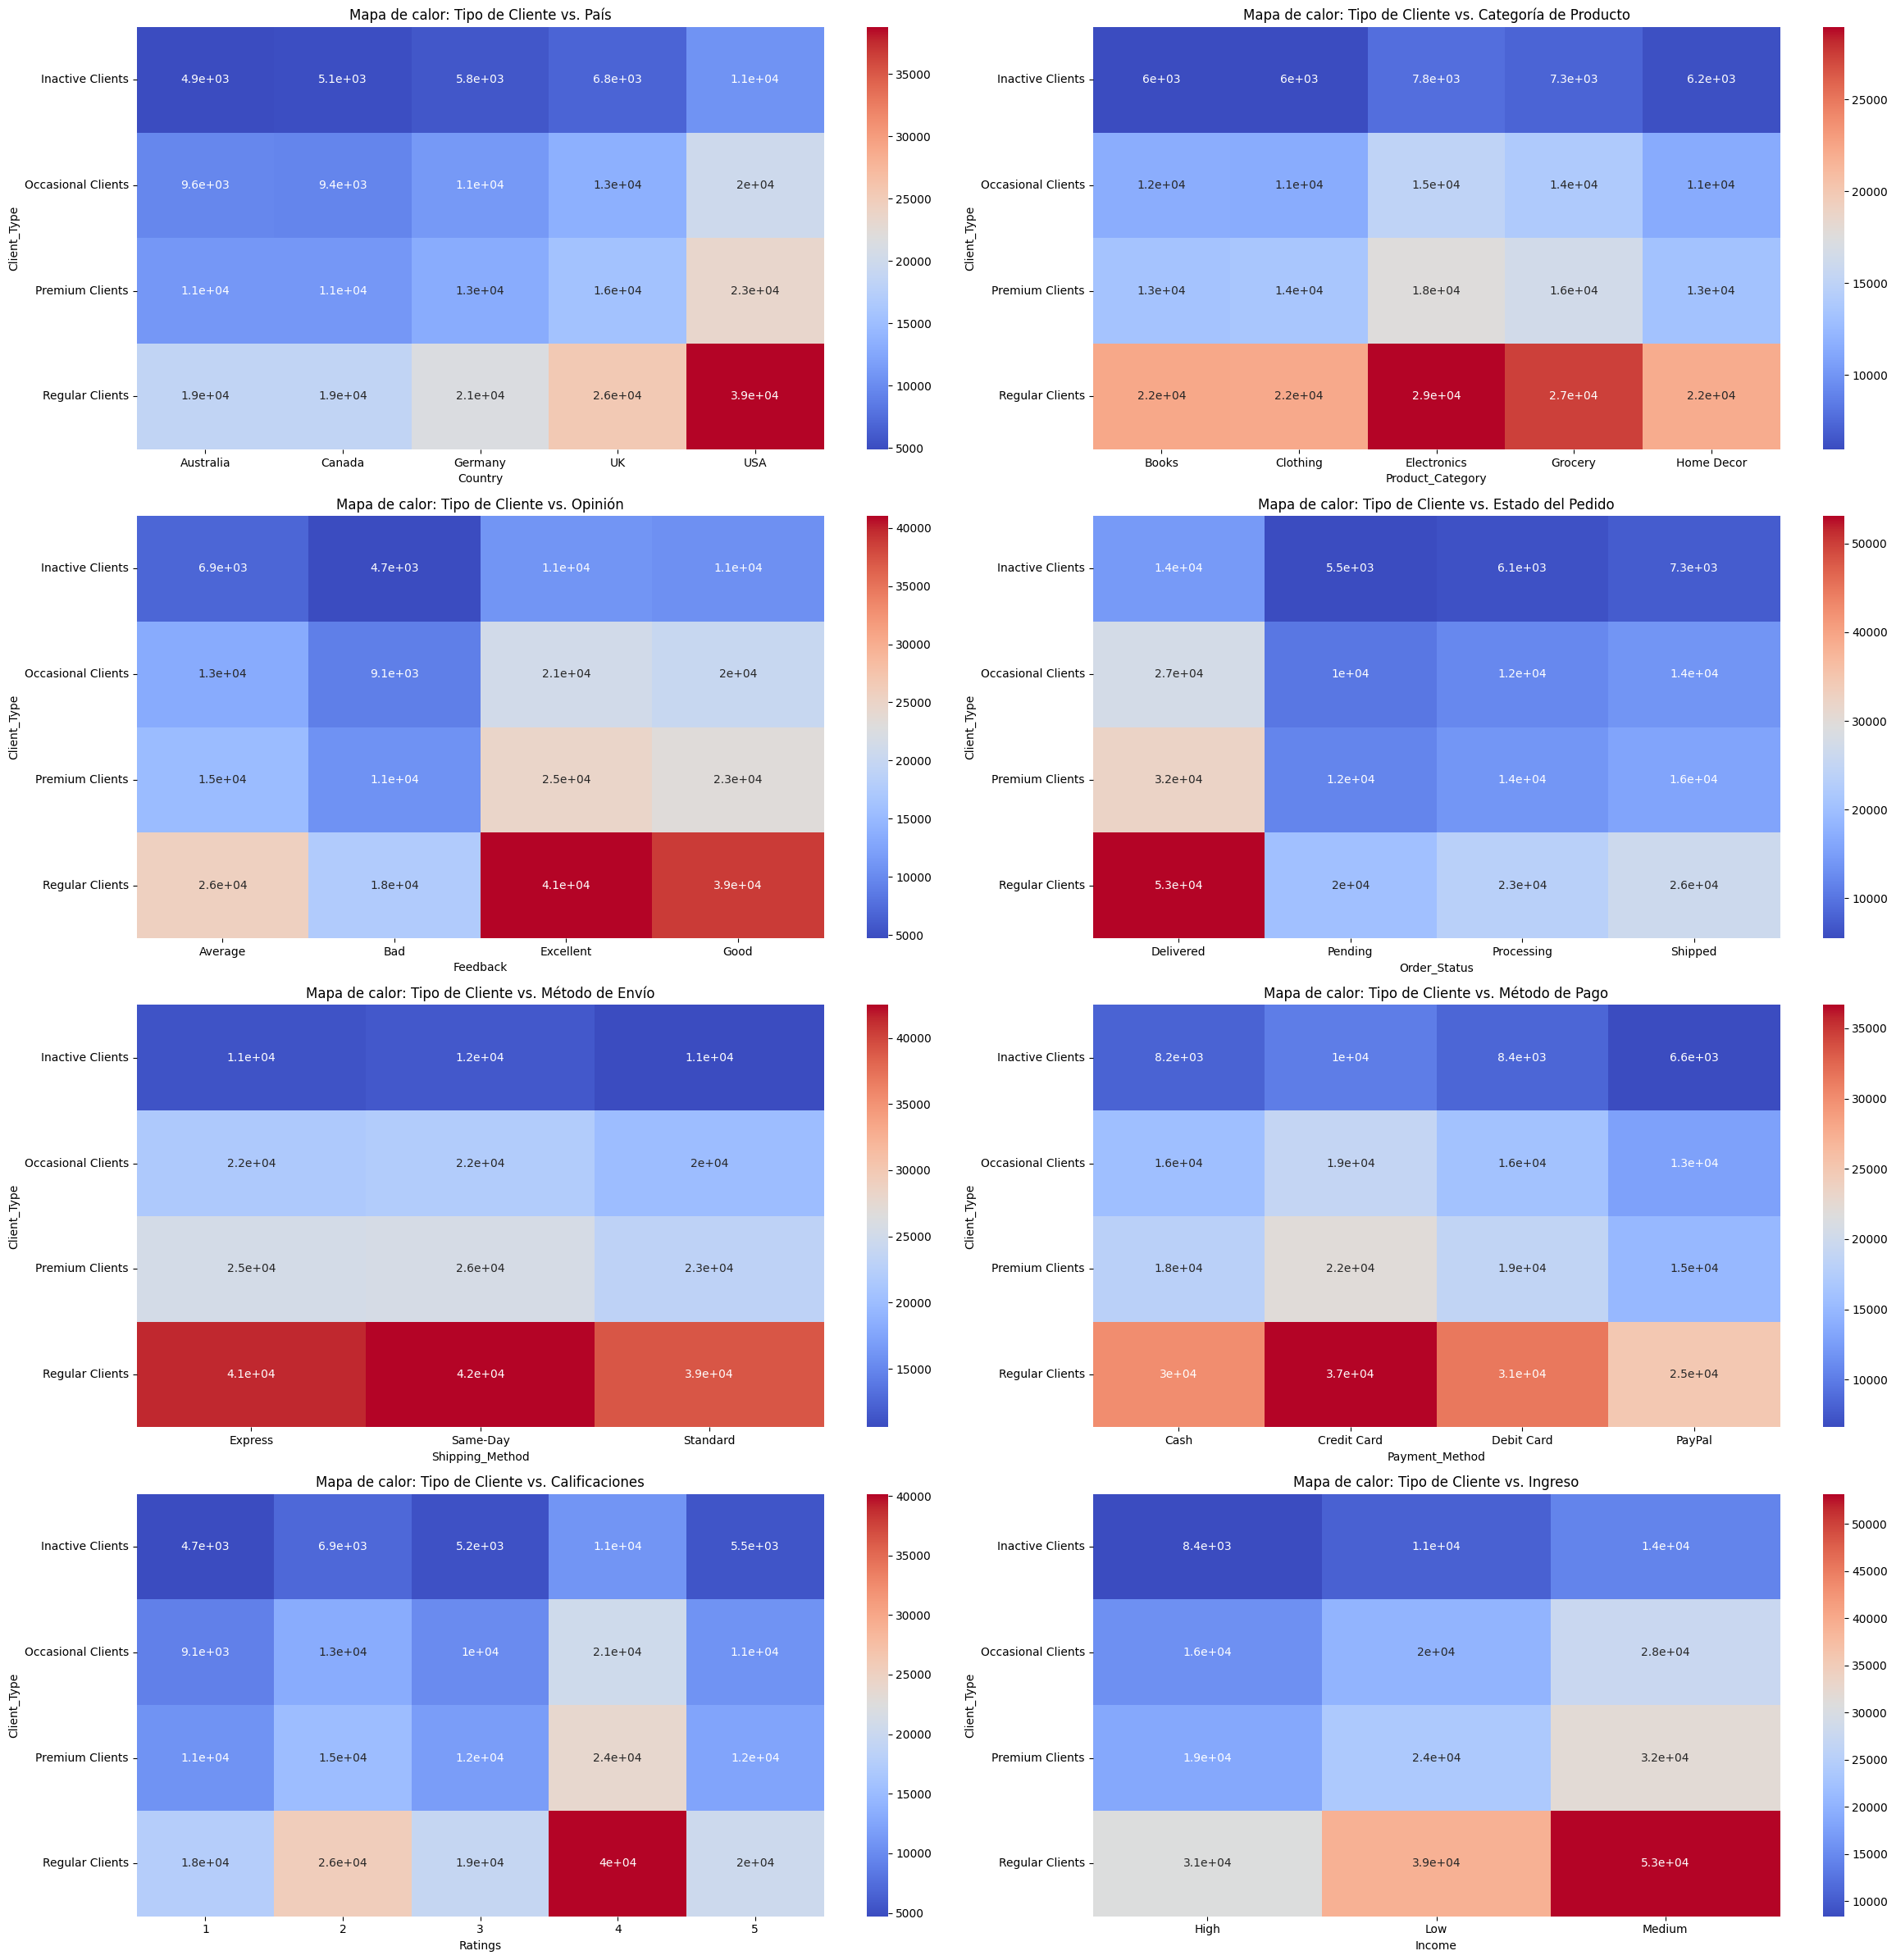

In [26]:
country_plot = dfm[['Client_Type','Country']].to_pandas()
category_plot = dfm[['Client_Type','Product_Category']].to_pandas()
feedback_plot = dfm[['Client_Type','Feedback']].to_pandas()
order_status_plot = dfm[['Client_Type','Order_Status']].to_pandas()
shipping_method_plot = dfm[['Client_Type','Shipping_Method']].to_pandas()
payment_method_plot = dfm[['Client_Type','Payment_Method']].to_pandas()
ratings_plot = dfm[['Client_Type','Ratings']].to_pandas()
income_plot = dfm[['Client_Type','Income']].to_pandas()

heatmap_country = country_plot.pivot_table(index='Client_Type', columns='Country', aggfunc='size', fill_value=0)
heatmap_category = category_plot.pivot_table(index='Client_Type', columns='Product_Category', aggfunc='size', fill_value=0)
heatmap_feedback = feedback_plot.pivot_table(index='Client_Type', columns='Feedback', aggfunc='size', fill_value=0)
heatmap_order_s = order_status_plot.pivot_table(index='Client_Type', columns='Order_Status', aggfunc='size', fill_value=0)
heatmap_shipping = shipping_method_plot.pivot_table(index='Client_Type', columns='Shipping_Method', aggfunc='size', fill_value=0)
heatmap_payment = payment_method_plot.pivot_table(index='Client_Type', columns='Payment_Method', aggfunc='size', fill_value=0)
heatmap_ratings = ratings_plot.pivot_table(index='Client_Type', columns='Ratings', aggfunc='size', fill_value=0)
heatmap_income = income_plot.pivot_table(index='Client_Type', columns='Income',  aggfunc='size', fill_value=0)

fig, axes = plt.subplots(4, 2, figsize=(24, 24))

sns.heatmap(heatmap_country, annot=True, cmap='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title('Mapa de calor: Tipo de Cliente vs. País')
sns.heatmap(heatmap_category, annot=True, cmap='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Mapa de calor: Tipo de Cliente vs. Categoría de Producto')
sns.heatmap(heatmap_feedback, annot=True, cmap='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Mapa de calor: Tipo de Cliente vs. Opinión')
sns.heatmap(heatmap_order_s, annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Mapa de calor: Tipo de Cliente vs. Estado del Pedido')
sns.heatmap(heatmap_shipping, annot=True, cmap='coolwarm', ax=axes[2, 0])
axes[2, 0].set_title('Mapa de calor: Tipo de Cliente vs. Método de Envío')
sns.heatmap(heatmap_payment, annot=True, cmap='coolwarm', ax=axes[2, 1])
axes[2, 1].set_title('Mapa de calor: Tipo de Cliente vs. Método de Pago')
sns.heatmap(heatmap_ratings, annot=True, cmap='coolwarm', ax=axes[3, 0])
axes[3, 0].set_title('Mapa de calor: Tipo de Cliente vs. Calificaciones')
sns.heatmap(heatmap_income, annot=True, cmap='coolwarm', ax=axes[3, 1])
axes[3, 1].set_title('Mapa de calor: Tipo de Cliente vs. Ingreso')

plt.tight_layout()
plt.show()

## Conclusiones Clave

- Segmentación efectiva: La segmentación en clientes regulares, premium y ocasionales es muy útil para entender las diferencias en comportamiento y preferencias.

- Personalización: Podemos ofrecer promociones y productos personalizados basados en el tipo de cliente. Por ejemplo, ofrecer envíos express a clientes premium o descuentos a clientes ocasionales.

- Experiencia del cliente: Los clientes premium valoran la rapidez y la calidad, mientras que los clientes regulares buscan opciones más económicas.

- Oportunidades de crecimiento: Podemos enfocarnos en convertir clientes ocasionales en regulares o premium ofreciendo mejores experiencias y promociones.

#### En resumen, poder dividir a los clientes por su valor nos permite entender mejor sus comportamientos!